In [1]:
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import torch
from scipy import stats
import sklearn
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import cv2
import numpy as np
import PIL
from PIL import Image, ImageChops, ImageDraw
from IPython.display import display
from skimage import io, img_as_float
from scipy.stats import ttest_ind, chi2_contingency, combine_pvalues

# Step 1
Load data

In [2]:
with uproot.open('toyForStudents_5.root') as datafile:
    data_df = datafile['R0Tree'].arrays(library='pd')

# Step 2
First data look

In [3]:
df = pd.DataFrame(data_df)
df

,x,y,id,sample
0,3.460569,0.673391,1,1
1,3.075171,0.761314,1,1
2,2.746258,1.339751,1,1
3,2.190463,2.049242,1,1
4,3.988466,0.707543,1,1
...,...,...,...,...
3399995,3.656641,0.730766,-1,17
3399996,5.113425,0.666245,-1,17
3399997,2.826508,1.441562,-1,17
3399998,3.683099,1.125471,-1,17


In [4]:
df_id_minus_1 = df[df['id'] == -1]
df_id_1 = df[df['id'] == 1]

In [5]:
df_id_minus_1

,x,y,id,sample
1700000,3.524324,2.084737,-1,1
1700001,3.497870,1.261757,-1,1
1700002,2.418601,1.440717,-1,1
1700003,3.495933,1.956262,-1,1
1700004,2.284854,2.110827,-1,1
...,...,...,...,...
3399995,3.656641,0.730766,-1,17
3399996,5.113425,0.666245,-1,17
3399997,2.826508,1.441562,-1,17
3399998,3.683099,1.125471,-1,17


In [6]:
df_id_1

,x,y,id,sample
0,3.460569,0.673391,1,1
1,3.075171,0.761314,1,1
2,2.746258,1.339751,1,1
3,2.190463,2.049242,1,1
4,3.988466,0.707543,1,1
...,...,...,...,...
1699995,2.924093,1.452403,1,17
1699996,2.067248,1.737031,1,17
1699997,2.581711,1.004430,1,17
1699998,4.302710,1.388870,1,17


In [7]:
def print_images():
    grouped_minus_1 = df_id_minus_1.groupby('sample')
    grouped_1 = df_id_1.groupby('sample')

    for sample, group_minus_1 in grouped_minus_1:
        group_1 = grouped_1.get_group(sample)

        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        # DLA id = -1
        axs[0].scatter(group_minus_1['x'], group_minus_1['y'], label='id = -1', color='blue', marker=',', s=1)
        axs[0].set_title(f'Obrazek dla sample {sample} (id = -1)')
        axs[0].set_xlabel('x')
        axs[0].set_ylabel('y')
        axs[0].legend()

        # DLA id = 1
        axs[1].scatter(group_1['x'], group_1['y'], label='id = 1', color='red', marker=",", s=1)
        axs[1].set_title(f'Obrazek dla sample {sample} (id = 1)')
        axs[1].set_xlabel('x')
        axs[1].set_ylabel('y')
        axs[1].legend()

        plt.tight_layout()
        plt.show()


# Step 3
Plots, interpolated

In [8]:
# print_images()

# Step 4
Save cloud points as png files to get exact images

In [9]:
def get_model_training_images(sample):
    data_id_minus_1 = df_id_minus_1[(df_id_minus_1['sample'] == sample) & (df_id_minus_1['id'] == -1)]
    data_id_1 = df_id_1[(df_id_1['sample'] == sample) & (df_id_1['id'] == 1)]

    return data_id_minus_1, data_id_1

In [10]:
a, b = get_model_training_images(17)

In [11]:
a

,x,y,id,sample
3300000,3.140368,2.036576,-1,17
3300001,3.498585,0.740953,-1,17
3300002,3.234064,1.930019,-1,17
3300003,2.658791,0.798944,-1,17
3300004,3.423107,2.123055,-1,17
...,...,...,...,...
3399995,3.656641,0.730766,-1,17
3399996,5.113425,0.666245,-1,17
3399997,2.826508,1.441562,-1,17
3399998,3.683099,1.125471,-1,17


In [12]:
b

,x,y,id,sample
1600000,4.465685,0.796268,1,17
1600001,4.763283,0.922533,1,17
1600002,2.679387,1.167562,1,17
1600003,3.276646,1.320163,1,17
1600004,3.004393,1.491962,1,17
...,...,...,...,...
1699995,2.924093,1.452403,1,17
1699996,2.067248,1.737031,1,17
1699997,2.581711,1.004430,1,17
1699998,4.302710,1.388870,1,17


In [13]:
# def save_point_cloud_as_image(dataframe, filename):
#     width = 500
#     height = 500

#     min_x = dataframe['x'].min()
#     max_x = dataframe['x'].max()
#     min_y = dataframe['y'].min()
#     max_y = dataframe['y'].max()

#     image = Image.new("RGB", (width, height), "white")
#     draw = ImageDraw.Draw(image)

#     for _, row in dataframe.iterrows():
#         x = int((row['x'] - min_x) / (max_x - min_x) * width)
#         y = int((row['y'] - min_y) / (max_y - min_y) * height)
#         draw.point((x, y), fill="black")

#     image.save(filename)

def save_point_cloud_as_image(dataframe, filename):
    width = 6000
    height = 6000
    padding = 5

    min_x = dataframe['x'].min()
    max_x = dataframe['x'].max()
    min_y = dataframe['y'].min()
    max_y = dataframe['y'].max()
    
    x_scale = (width - 2 * padding) / (max_x - min_x)
    y_scale = (height - 2 * padding) / (max_y - min_y)

    image = Image.new("RGB", (width, height), "white")
    draw = ImageDraw.Draw(image)

    for _, row in dataframe.iterrows():
        x = int((row['x'] - min_x) * x_scale) + padding
        y = int((row['y'] - min_y) * y_scale) + padding
        draw.point((x, height - y - 1), fill="black")  # Invert y to match image coordinates

    image.save(filename)


In [14]:
for i in range(1, 2, 1):
    print(f"========== SAMPLE {i} ==========")
    img_minus, img = get_model_training_images(i)
    save_point_cloud_as_image(img_minus, f"cloud_points_to_images_minus/img_minus_{i}.png")
    save_point_cloud_as_image(img, f"cloud_points_to_images/img_{i}.png")
    print(f"Sample {i} saved to cloud_points_to_images/ folder.")
print(f"================================")
print("Conversion done.")

========== SAMPLE 1 ==========
Sample 1 saved to cloud_points_to_images/ folder.
Conversion done.


# Step 5
Cluster analysis
https://scikit-learn.org/stable/modules/clustering.html

## PIL library

In [15]:
def PIL_diff(img1, img2):
    diff = ImageChops.difference(img1, img2)
    if diff.getbbox():
        # yellow_bg = Image.new("RGB", diff.size, "yellow")
        # result = ImageChops.add(yellow_bg, diff)
        # display(result)
        display(diff)
    else:
        print("No differences")

In [16]:
def load_image_from_folder(folder, filename):
    path = f"{folder}/{filename}"
    return Image.open(path)

img_minus_1_loaded = load_image_from_folder("cloud_points_to_images_minus", "img_minus_1.png")
img_1_loaded = load_image_from_folder("cloud_points_to_images", "img_1.png")

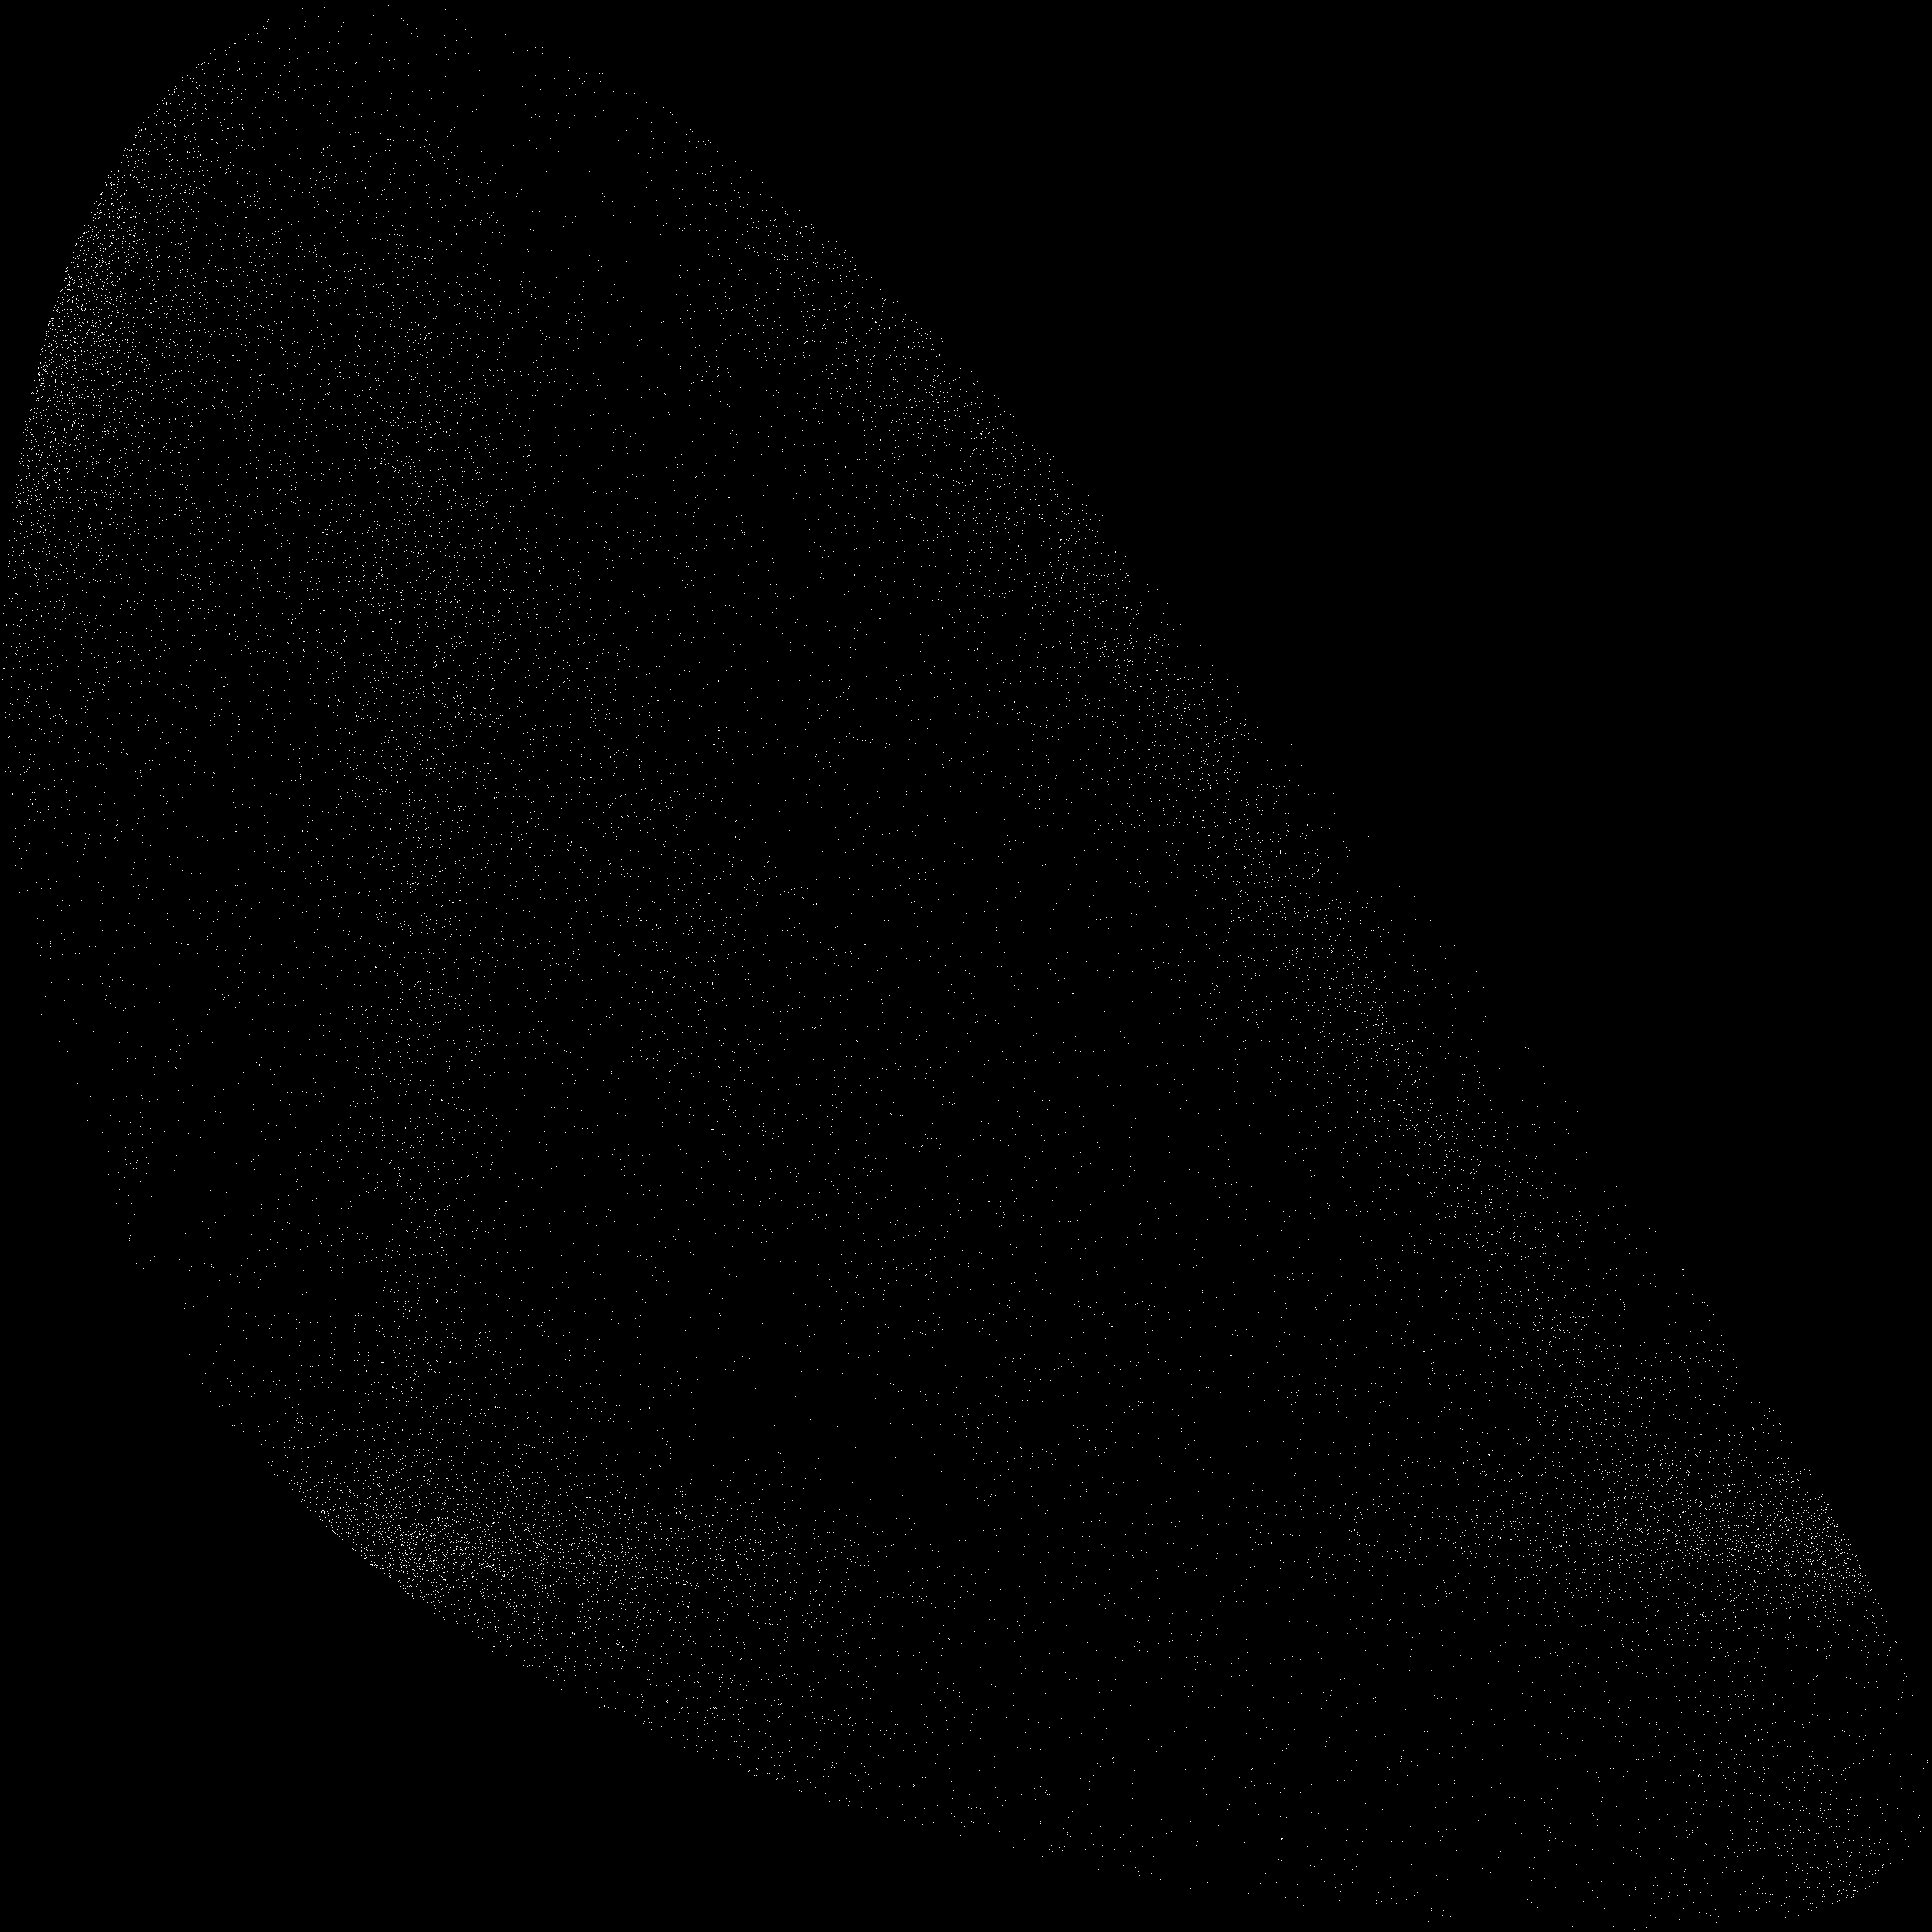

In [17]:
PIL_diff(img_minus_1_loaded, img_1_loaded)

## TESTS FOR PILL LIB METHOD DIFF

In [18]:
x_coordinates = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 15, 25, 35]
y_coordinates = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 15, 25, 35]

df1 = pd.DataFrame({
    'x': x_coordinates,
    'y': y_coordinates,
    'id': 1,
    'sample': 1
})

x_coordinates = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 55, 65, 75]
y_coordinates = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 55, 65, 75]

df2 = pd.DataFrame({
    'x': x_coordinates,
    'y': y_coordinates,
    'id': -1,
    'sample': -1
})

df_test = pd.concat([df1, df2], ignore_index=True)
#df

In [19]:
df_id_minus_1_test = df_test[df_test['id'] == -1]
df_id_1_test = df_test[df_test['id'] == 1]


In [20]:
def print_images2():

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # DLA id = -1
    axs[0].scatter(df_id_minus_1_test['x'], df_id_minus_1_test['y'], label='id = -1', color='blue', marker=',', s=10)
    axs[0].set_title(f'Obrazek dla sample (id = -1)')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    axs[0].legend()

    # DLA id = 1
    axs[1].scatter(df_id_1_test['x'], df_id_1_test['y'], label='id = 1', color='red', marker=",", s=10)
    axs[1].set_title(f'Obrazek dla sample (id = 1)')
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    axs[1].legend()

    plt.tight_layout()
    plt.show()


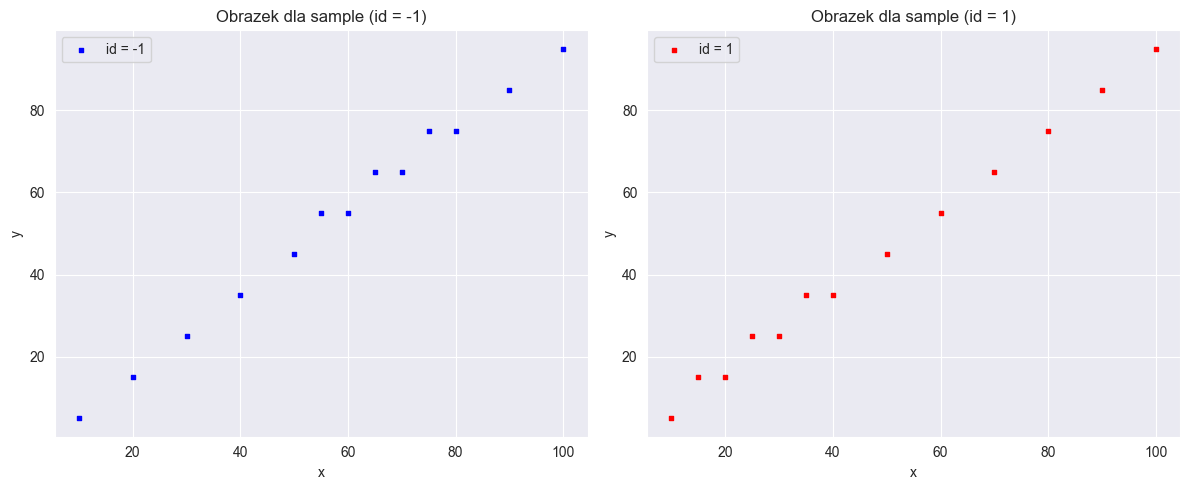

In [21]:
print_images2()

In [22]:
def get_model_training_images():
    data_id_minus_1 = df_id_minus_1_test[(df_id_minus_1_test['sample']) & (df_id_minus_1_test['id'] == -1)]
    data_id_1 = df_id_1_test[(df_id_1_test['sample']) & (df_id_1_test['id'] == 1)]

    return data_id_minus_1, data_id_1

img_minus, img = get_model_training_images()
save_point_cloud_as_image(img_minus, f"test/img_minus_1.png")
save_point_cloud_as_image(img, f"test/img_1.png")
print(f"================================")
print("Conversion done.")


save_point_cloud_as_image(img_minus, f"test/img_minus_1.png")
save_point_cloud_as_image(img, f"test/img_1.png")


Conversion done.


In [23]:
img_test_minus_1 = load_image_from_folder("test", "img_minus_1.png")
img_test_1 = load_image_from_folder("test", "img_1.png")

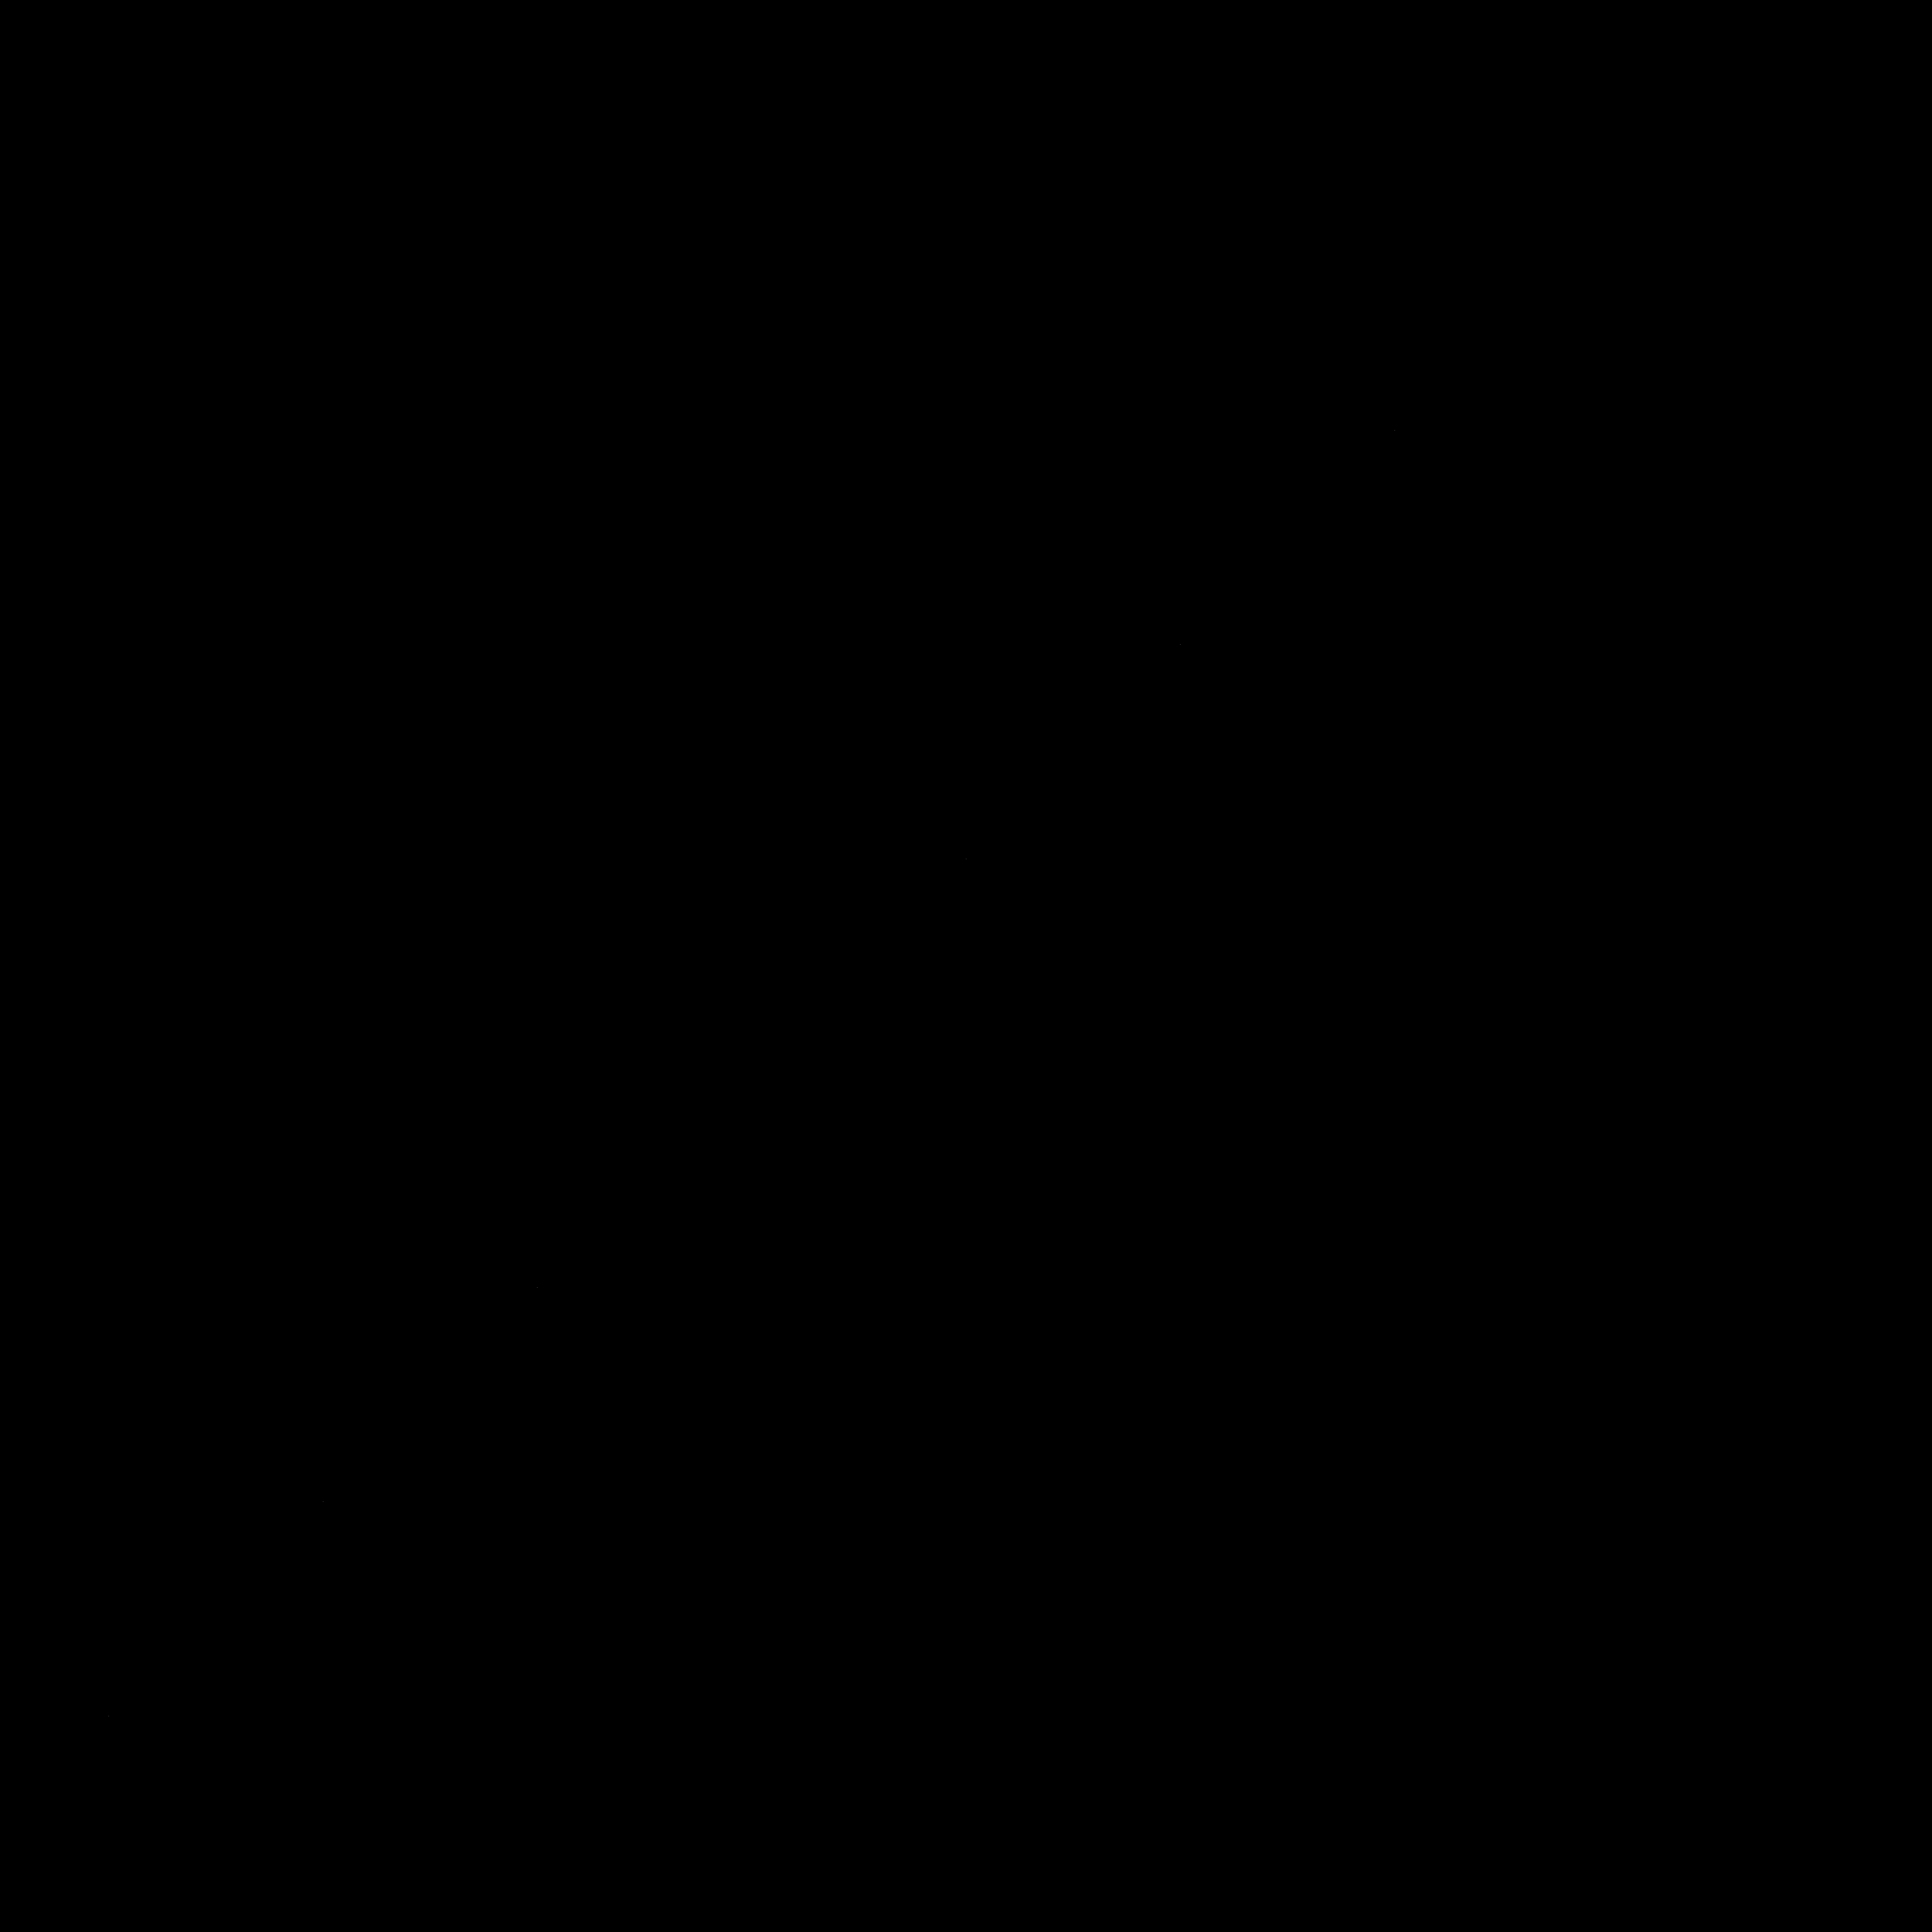

In [24]:
PIL_diff(img_test_minus_1, img_test_1)

In [25]:
df_id_minus_1 = df[df['id'] == -1]
df_id_minus_1
grouped_minus_1 = df_id_minus_1[df_id_minus_1['sample'] == 1]
grouped_minus_1
# grouped_minus_1 = df_id_minus_1.groupby('sample')
# grouped_minus_1
# grouped_minus_1_s_1 = grouped_minus_1['sample'] == 1
# grouped_minus_1_s_1

,x,y,id,sample
1700000,3.524324,2.084737,-1,1
1700001,3.497870,1.261757,-1,1
1700002,2.418601,1.440717,-1,1
1700003,3.495933,1.956262,-1,1
1700004,2.284854,2.110827,-1,1
...,...,...,...,...
1799995,4.818124,0.807776,-1,1
1799996,4.082955,0.873010,-1,1
1799997,5.049155,0.740994,-1,1
1799998,3.069079,1.227595,-1,1


In [26]:
img = cv2.imread('cloud_points_to_images_minus/img_minus_1.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Przygotuj dane
# points = img_gray.reshape((-1, 1))
# print(points)
threshold = 200  # Próg binaryzacji
points = np.where(img_gray == 0)

# Zapisz współrzędne punktów jako tablicę (x, y)
coordinates = np.column_stack((points[1], points[0]))
df_coordinates = pd.DataFrame(coordinates, columns=['x', 'y'])
# print(df_coordinates)
df_coordinates

,x,y
0,1050,4
1,1165,5
2,1225,5
3,1068,6
4,1184,6
...,...,...
99497,5076,5992
99498,4920,5993
99499,5041,5993
99500,5067,5993


## K-Means

In [27]:
def detect_image_differences(img1, img2, num_clusters=2):
    # img1_array = img_as_float(img1)
    # img2_array = img_as_float(img2)

    # img1_flat = img1_array.reshape((-1, 3))
    # img2_flat = img2_array.reshape((-1, 3))
    # print(img1_flat)

    # load first picture in gray
    img = cv2.imread('cloud_points_to_images_minus/img_minus_1.png')
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # save all black pixels and its location as x y
    points = np.where(img_gray == 0)
    coordinates = np.column_stack((points[1], points[0]))
    df_coordinates = pd.DataFrame(coordinates, columns=['x', 'y'])

    # load second picture in gray
    img2 = cv2.imread('cloud_points_to_images/img_1.png')
    img_gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # save all black pixels and its location as x y
    points2 = np.where(img_gray2 == 0)
    coordinates2 = np.column_stack((points2[1], points2[0]))
    df_coordinates2 = pd.DataFrame(coordinates2, columns=['x', 'y'])
    # print(df_coordinates)

    
    combined_data = np.vstack((df_coordinates, df_coordinates2))

    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}
    K = range(1, 15)

    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(combined_data)
        kmeanModel.fit(combined_data)

        # distortions
        distortions.append(sum(np.min(cdist(combined_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / combined_data.shape[0])

        # inertias
        inertias.append(kmeanModel.inertia_)

        mapping1[k] = sum(np.min(cdist(combined_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / combined_data.shape[0]
        mapping2[k] = kmeanModel.inertia_

    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method using Distortion')
    plt.show()

    plt.plot(K, inertias, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method using Inertia')
    plt.show()

    num_clusters = num_clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(combined_data)

    # add cluster value to each coordinates
    df_coordinates['cluster'] = labels[:len(df_coordinates)]
    df_coordinates2['cluster'] = labels[len(df_coordinates):]

    combined_data_clusters = np.vstack((df_coordinates, df_coordinates2))
    combined_data_clusters = pd.DataFrame(combined_data_clusters, columns=['x', 'y', 'cluster'])
    
    # Konwersja różnic z powrotem na wymiary obrazu
    # differences_img = differences.reshape(img_gray.shape)
    # differences_indices = np.where(labels1 != labels2)[0]
    # differences_coordinates = df_coordinates.iloc[differences_indices]
    # df_coordinates['cluster'] = labels1
    # df_coordinates2['cluster'] = labels2

    # print(df_coordinates)

    # to chyba nie ma sensu
    differences_coordinates = df_coordinates[df_coordinates['cluster'] == df_coordinates['cluster']]
    diff_xy = differences_coordinates[['x', 'y']]

    plt.figure(figsize=(8, 6))
    for cluster in range(num_clusters):
        cluster_points = combined_data_clusters[combined_data_clusters['cluster'] == cluster]
        plt.scatter(cluster_points['x'], cluster_points['y'], label=f'Cluster {cluster}', alpha=0.5, s=1)
    # plt.scatter(differences_coordinates['x'], differences_coordinates['y'], color='red', label='Different Clusters', s=1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Combined image')
    plt.legend()


    plt.figure(figsize=(8, 6))
    for cluster in range(num_clusters):
        cluster_points = df_coordinates[df_coordinates['cluster'] == cluster]
        plt.scatter(cluster_points['x'], cluster_points['y'], label=f'Cluster {cluster}', alpha=0.5, s=1)
    # plt.scatter(differences_coordinates['x'], differences_coordinates['y'], color='red', label='Different Clusters', s=1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('First image')
    plt.legend()

    plt.figure(figsize=(8, 6))
    for cluster in range(num_clusters):
        cluster_points = df_coordinates2[df_coordinates2['cluster'] == cluster]
        plt.scatter(cluster_points['x'], cluster_points['y'], label=f'Cluster {cluster}', alpha=0.5, s=1)
    # plt.scatter(differences_coordinates['x'], differences_coordinates['y'], color='red', label='Different Clusters', s=1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Second image')
    plt.legend()
    plt.show()

    # print(differences_coordinates)
    return diff_xy

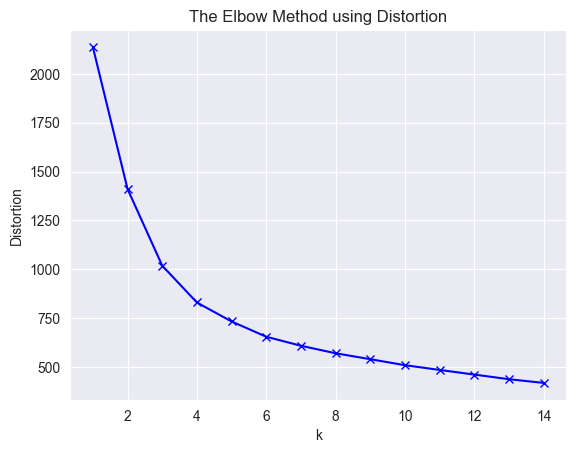

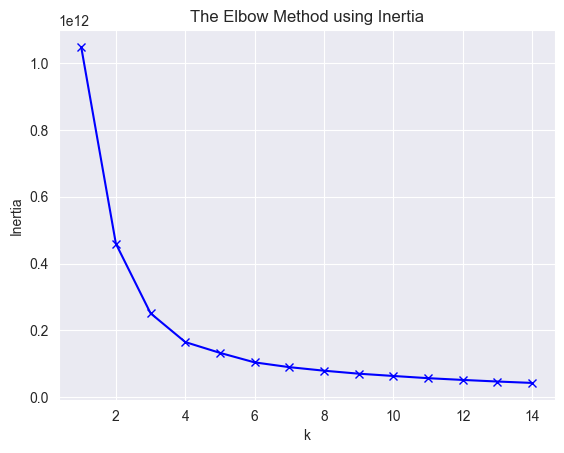

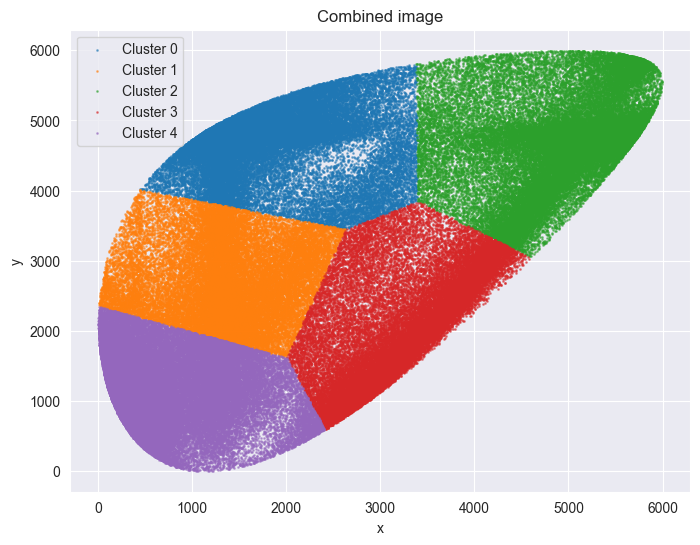

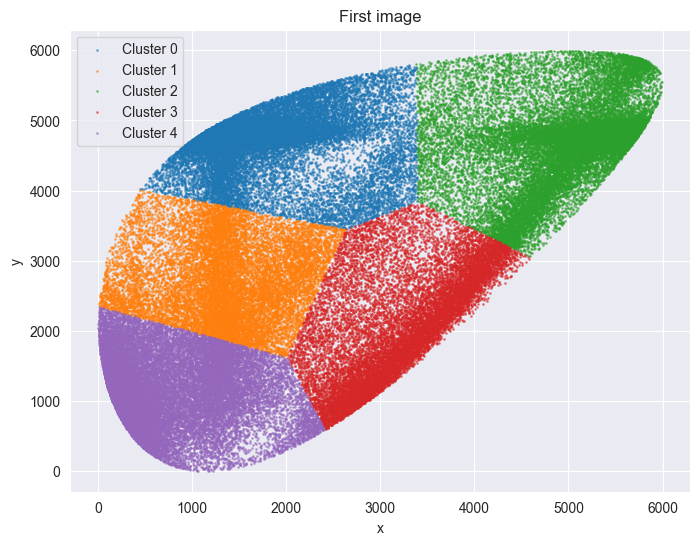

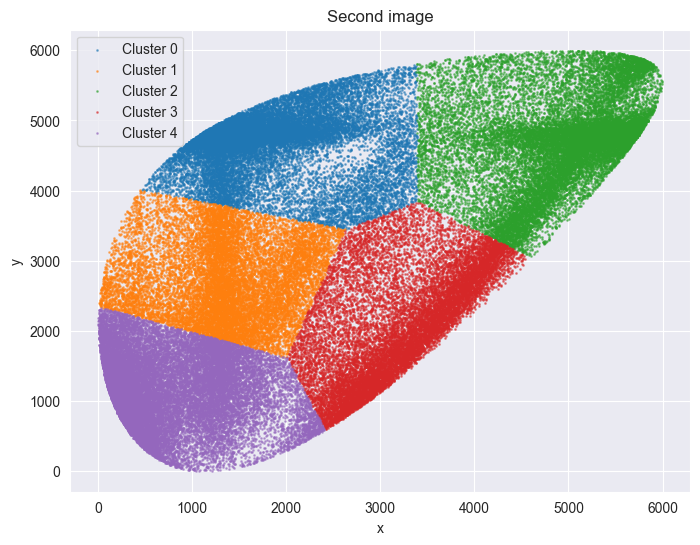

In [28]:
differences_img = detect_image_differences(img_minus_1_loaded, img_1_loaded, 5)

save_point_cloud_as_image(differences_img, "test/test_differences.png")

# io.imshow(differences_img, cmap='gray')
# io.show()

## Metoda Fishera
Polega na połączeniu kilku p-wartości w jedną skumulowaną p-wartość, co pozwala na jednoczesne uwzględnienie wyników kilku niezależnych testów.

In [29]:
img = cv2.imread('cloud_points_to_images_minus/img_minus_1.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# save all black pixels and its location as x y
points = np.where(img_gray == 0)
coordinates = np.column_stack((points[1], points[0]))
df_coordinates = pd.DataFrame(coordinates, columns=['x', 'y'])

# load second picture in gray
img2 = cv2.imread('cloud_points_to_images/img_1.png')
img_gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# save all black pixels and its location as x y
points2 = np.where(img_gray2 == 0)
coordinates2 = np.column_stack((points2[1], points2[0]))
df_coordinates2 = pd.DataFrame(coordinates2, columns=['x', 'y'])
# print(df_coordinates)

combined_data = np.vstack((df_coordinates, df_coordinates2))

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(combined_data)

# add cluster value to each coordinates
df_coordinates['cluster'] = labels[:len(df_coordinates)]
df_coordinates2['cluster'] = labels[len(df_coordinates):]

combined_data_clusters = np.vstack((df_coordinates, df_coordinates2))
combined_data_clusters = pd.DataFrame(combined_data_clusters, columns=['x', 'y', 'cluster'])



cluster_counts_df1 = df_coordinates.groupby('cluster').size().rename('size_df1')
cluster_counts_df2 = df_coordinates2.groupby('cluster').size().rename('size_df2')

cluster_comparison = pd.merge(cluster_counts_df1, cluster_counts_df2, how='outer', left_index=True, right_index=True)

cluster_comparison['p_df1'] = cluster_comparison['size_df1'] / cluster_comparison['size_df1'].sum()
cluster_comparison['p_df2'] = cluster_comparison['size_df2'] / cluster_comparison['size_df2'].sum()

cluster_comparison['df1_to_df2'] = cluster_comparison['size_df1'] / cluster_comparison['size_df2']

print(cluster_comparison)
print()



from scipy.stats import chi2_contingency


observed = cluster_comparison[['size_df1', 'size_df2']].values

density_comparison = cluster_comparison['size_df1'] / cluster_comparison['size_df2']

chi2, p, dof, expected = chi2_contingency(observed)

print("Wartość statystyki chi-kwadrat:", chi2)
print("Wartość p:", p)
print("Stopnie swobody:", dof)
print("Oczekiwane wartości:", expected)
# print("Porównanie wartości gęstości punktów w klastrach df_coordinates do df_coordinates2:")
# density_comparison



# chi-kwadrat (chi2) informuje o sile różnic między obserwowanymi a oczekiwanymi wartościami
# niska wartość p ( <0,05) oznacza, że różnice są istotne
# ozekiwane częstości (expected) to wartości, które zostałyby otrzymane, gdyby obserwowane wartości były zgodne z rozkładem spodziewanym


         size_df1  size_df2     p_df1     p_df2  df1_to_df2
cluster                                                    
0           21722     21099  0.218307  0.212016    1.029527
1           15287     15547  0.153635  0.156226    0.983277
2           22718     22128  0.228317  0.222356    1.026663
3           15449     15951  0.155263  0.160286    0.968529
4           24326     24791  0.244477  0.249116    0.981243

Wartość statystyki chi-kwadrat: 31.44535561599555
Wartość p: 2.4833252800375102e-06
Stopnie swobody: 4
Oczekiwane wartości: [[21408.9938699  21412.0061301 ]
 [15415.91548503 15418.08451497]
 [22421.42264519 22424.57735481]
 [15698.89557728 15701.10442272]
 [24556.77242259 24560.22757741]]


In [30]:

from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

expected_density_comparison = cluster_comparison['size_df1'].sum() / cluster_comparison['size_df2'].sum()

# print("\n\n", expected_density_comparison, "\n\n")

density_comparison_array = np.array(density_comparison)

observed_array = np.array([density_comparison_array, [expected_density_comparison] * len(density_comparison)])

print("\n", density_comparison_array, "\n")

print("\n", observed_array, "\n")

chi2_density, p_density, _, expected_density = chi2_contingency(observed_array)

print("Wartość statystyki chi-kwadrat dla porównania gęstości punktów w klastrach:")
print(chi2_density)
print("Wartość p dla porównania gęstości punktów w klastrach:")
print(p_density)
print("Oczekiwane gęstości do klastrów:", expected_density)
print(expected_density)


# Pierwszy wiersz expected_density zawiera oczekiwane gęstości punktów dla każdego klastra, zakładając, że gęstość punktów jest równomierna między klastrami
# Drugi wiersz expected_density zawiera oczekiwane gęstości punktów, które zostały znormalizowane, aby suma gęstości w każdym klastrze wynosiła 1


# Test t-studenta
t_statistic, p_value = ttest_ind(density_comparison, [expected_density_comparison]*len(density_comparison))

print("Wartość statystyki t dla porównania gęstości punktów w klastrach:")
print(t_statistic)
print("Wartość p dla porównania gęstości punktów w klastrach:")
print(p_value)


# t określa różnicę między średnimi gęstościami punktów w klastrach dla obu zbiorów danych. 
# Im większa wartość t, tym większe są różnice między grupami. Wartość t bliska zeru sugeruje, że nie ma istotnych różnic między gęstościami punktów

# małe wartości p sugerują, że różnice między grupami są istotne statystycznie, podczas gdy wysokie wartości p sugerują, że różnice nie są istotne



 [1.02952747 0.98327652 1.02666305 0.96852862 0.98124319] 


 [[1.02952747 0.98327652 1.02666305 0.96852862 0.98124319]
 [0.99985932 0.99985932 0.99985932 0.99985932 0.99985932]] 

Wartość statystyki chi-kwadrat dla porównania gęstości punktów w klastrach:
0.0015904049552785968
Wartość p dla porównania gęstości punktów w klastrach:
0.9999996839940745
Oczekiwane gęstości do klastrów: [[1.01367167 0.99056948 1.0122409  0.98320296 0.98955384]
 [1.01571512 0.99256636 1.01428147 0.98518498 0.99154867]]
[[1.01367167 0.99056948 1.0122409  0.98320296 0.98955384]
 [1.01571512 0.99256636 1.01428147 0.98518498 0.99154867]]
Wartość statystyki t dla porównania gęstości punktów w klastrach:
-0.15948693775064127
Wartość p dla porównania gęstości punktów w klastrach:
0.8772383176085525


C:\Users\szymo\AppData\Local\Temp\ipykernel_16160\1254755713.py:31: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistic, p_value = ttest_ind(density_comparison, [expected_density_comparison]*len(density_comparison))


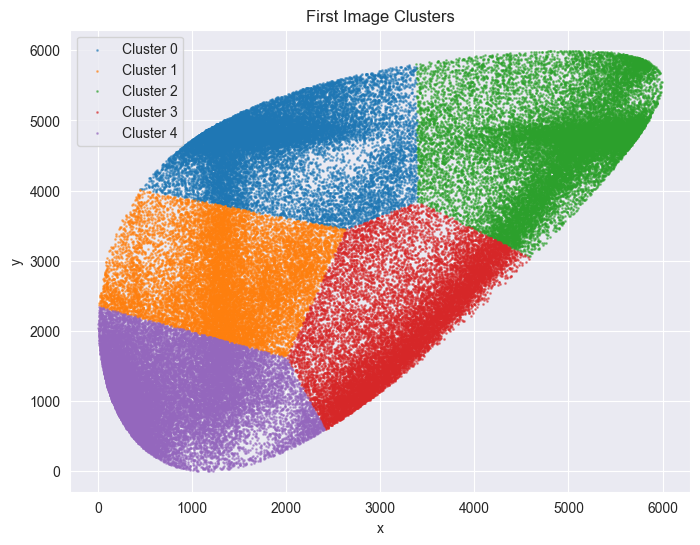

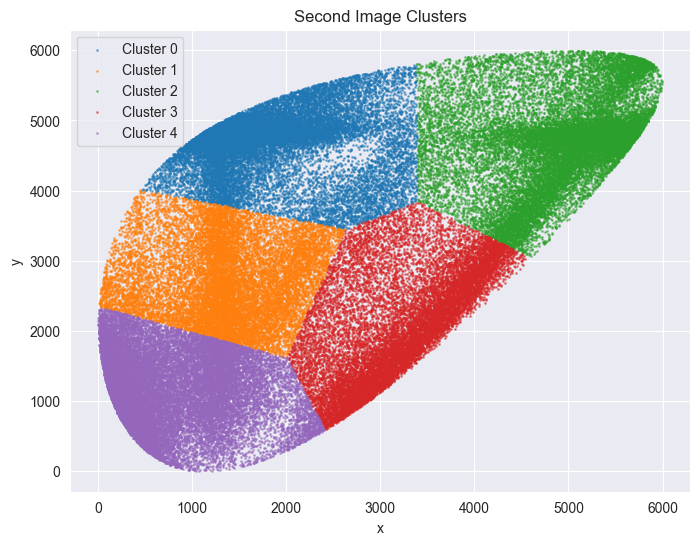

Cluster 0:
  T-test for x-coordinates: statistic=-3.614685034453402, p-value=0.0003010581867448551
  T-test for y-coordinates: statistic=1.7600718764448313, p-value=0.07840277572467097
  Combined p-value for x and y coordinates: 0.0002750810859767962
  Chi-squared test: chi2=20.365516740716743, p-value=0.01578589855880001

Cluster 1:
  T-test for x-coordinates: statistic=0.14066478911268593, p-value=0.8881356817172001
  T-test for y-coordinates: statistic=-0.8576271382920496, p-value=0.39110505184325883
  Combined p-value for x and y coordinates: 0.7146502590938817
  Chi-squared test: chi2=2.5011049704886235, p-value=0.9808537604183886

Cluster 2:
  T-test for x-coordinates: statistic=1.8028707677324824, p-value=0.07141523156785216
  T-test for y-coordinates: statistic=-1.7871751487100587, p-value=0.07391594896378262
  Combined p-value for x and y coordinates: 0.032960730005197086
  Chi-squared test: chi2=12.583061933419016, p-value=0.18239733656907564

Cluster 3:
  T-test for x-coordi

In [42]:
def detect_image_differences(img1_path, img2_path, num_clusters=2):
    
    img1 = cv2.imread(img1_path)
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    points1 = np.where(img1_gray == 0)
    coordinates = np.column_stack((points1[1], points1[0]))
    df_coordinates = pd.DataFrame(coordinates, columns=['x', 'y'])

    
    img2 = cv2.imread(img2_path)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    points2 = np.where(img2_gray == 0)
    coordinates2 = np.column_stack((points2[1], points2[0]))
    df_coordinates2 = pd.DataFrame(coordinates2, columns=['x', 'y'])

    combined_data = np.vstack((df_coordinates, df_coordinates2))

    num_clusters = num_clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(combined_data)

    # add cluster value to each coordinates
    df_coordinates['cluster'] = labels[:len(df_coordinates)]
    df_coordinates2['cluster'] = labels[len(df_coordinates):]


    plt.figure(figsize=(8, 6))
    for cluster in range(num_clusters):
        cluster_points = df_coordinates[df_coordinates['cluster'] == cluster]
        plt.scatter(cluster_points['x'], cluster_points['y'], label=f'Cluster {cluster}', alpha=0.5, s=1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('First Image Clusters')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    for cluster in range(num_clusters):
        cluster_points = df_coordinates2[df_coordinates2['cluster'] == cluster]
        plt.scatter(cluster_points['x'], cluster_points['y'], label=f'Cluster {cluster}', alpha=0.5, s=1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Second Image Clusters')
    plt.legend()
    plt.show()

    results = []
    for cluster in range(num_clusters):
        points_img1 = df_coordinates[df_coordinates['cluster'] == cluster]
        points_img2 = df_coordinates2[df_coordinates2['cluster'] == cluster]

        if len(points_img1) == 0 or len(points_img2) == 0:
            continue

        # T-test for the x and y coordinates separately, then combined values
        ttest_x = ttest_ind(points_img1['x'], points_img2['x'], equal_var=False)
        ttest_y = ttest_ind(points_img1['y'], points_img2['y'], equal_var=False)

        # Fisher's method
        combined_p_value = combine_pvalues([ttest_x.pvalue, ttest_y.pvalue], method='fisher')[1]


        # # #
        # # TODO: fix that chi2 for all x y values
        # # Perform chi-square test for the distributions
        # obs = np.array([len(points_img1), len(points_img2)])
        # chi2, p = chi2_contingency([obs])[0:2]

        # Create contingency table for chi-squared test
        # Assuming 'x' and 'y' ranges are divided into bins or categories
        contingency_table = np.array([
            np.histogram(points_img1['x'], bins=10)[0],
            np.histogram(points_img2['x'], bins=10)[0]
        ])
        chi2, p, dof, expected = chi2_contingency(contingency_table)


        results.append({
            'cluster': cluster,
            'ttest_x': ttest_x,
            'ttest_y': ttest_y,
            'combined_p_value': combined_p_value,
            'chi2': chi2,
            'p_value': p
        })

    for result in results:
        print(f"Cluster {result['cluster']}:")
        print(f"  T-test for x-coordinates: statistic={result['ttest_x'].statistic}, p-value={result['ttest_x'].pvalue}")
        print(f"  T-test for y-coordinates: statistic={result['ttest_y'].statistic}, p-value={result['ttest_y'].pvalue}")
        print(f"  Combined p-value for x and y coordinates: {result['combined_p_value']}")
        print(f"  Chi-squared test: chi2={result['chi2']}, p-value={result['p_value']}")
        print()

    return df_coordinates, df_coordinates2, results

img1_path = 'cloud_points_to_images_minus/img_minus_1.png'
img2_path = 'cloud_points_to_images/img_1.png'
df_coordinates, df_coordinates2, stats_results = detect_image_differences(img1_path, img2_path, num_clusters=5)


# Loop through whole dataset

In [36]:
max_sample = df['sample'].max()
print("Max value for 'sample' column:", max_sample)

Największa wartość w kolumnie 'sample': 17


In [38]:
for i in range(1, max_sample+1):
    print(f"{i} - XD")

1 - XD
2 - XD
3 - XD
4 - XD
5 - XD
6 - XD
7 - XD
8 - XD
9 - XD
10 - XD
11 - XD
12 - XD
13 - XD
14 - XD
15 - XD
16 - XD
17 - XD
